### Not an improvement over other models, used FeatureUnion

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.neighbors import KNeighborsClassifier



In [2]:
df = pd.read_csv('./data/cleaned_engineered.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
# set X and y
X = df.drop(columns=['subreddit', 'created_utc'])
y = df['topics']
#baseline
y.value_counts(normalize=True)

0    0.500119
1    0.499881
Name: topics, dtype: float64

In [4]:
# train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

def get_title(df):
    return df['title']

get_title_transformer = FunctionTransformer(get_title, validate=False)

In [6]:
def get_other_columns(df):
    return df[['sentiment_neg', 'sentiment_compound']]

get_other_columns_transformer = FunctionTransformer(get_other_columns, validate=False)

In [7]:
inner_pipe = Pipeline([
    ('title_transform', get_title_transformer),
    ('vect', CountVectorizer())
])

In [8]:
outer_pipe = Pipeline([
    ('feats', FeatureUnion([
        ('vect_pipe', inner_pipe),
        ('other_cols', get_other_columns_transformer)
    ])),
    ('lr', LogisticRegression())
])

In [9]:
params = {
     'feats__vect_pipe__vect__stop_words': [None, 'english'],
     'feats__vect_pipe__vect__min_df': [1,2,3,4],
     'feats__vect_pipe__vect__max_df': [1.0, .75, .5, .25],
     'feats__vect_pipe__vect__binary': [True, False],
     'feats__vect_pipe__vect__max_features': [None, 4000, 5000],
#      'tfid__ngram_range': [(1,2)],
# #    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#      'dt__max_depth': [10], 
#      'dt__min_samples_split': [2], 
#      'dt__min_samples_leaf': [1], 
#      'dt__ccp_alpha': [0.01],
#      'dt__class_weight': None,
#      'dt__criterion': 'gini',
#      'dt__max_features': None,
#      'dt__max_leaf_nodes': None,
#      'dt__min_impurity_decrease': 0.0,
#      'dt__min_impurity_split': None,
#      'dt__min_weight_fraction_leaf': 0.0,
#      'dt__random_state': [42],
#      'dt__splitter': 'best'
}

gs = GridSearchCV(outer_pipe,
                  param_grid=params,
                  verbose=1)
gs.fit(X_train, y_train)
print(gs.best_score_) # <- cross val score FTW
gs.best_params_

Fitting 5 folds for each of 192 candidates, totalling 960 fits
0.9158467711408887


{'feats__vect_pipe__vect__binary': True,
 'feats__vect_pipe__vect__max_df': 1.0,
 'feats__vect_pipe__vect__max_features': 4000,
 'feats__vect_pipe__vect__min_df': 1,
 'feats__vect_pipe__vect__stop_words': 'english'}

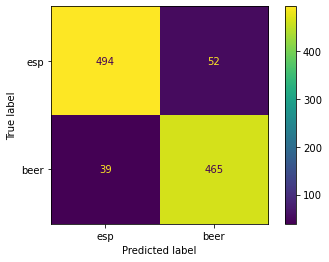

In [10]:
plot_confusion_matrix(gs, X_test, y_test, display_labels=['esp', 'beer']);

In [11]:
gs.score(X_train, y_train)

0.984757065735154

In [12]:
gs.score(X_test, y_test)

0.9133333333333333

In [13]:
pred = gs.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       546
           1       0.90      0.92      0.91       504

    accuracy                           0.91      1050
   macro avg       0.91      0.91      0.91      1050
weighted avg       0.91      0.91      0.91      1050



This model performs at roughly the same rate as others.